In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split

### NOTE: The only methods you are required to have are:
#   * predict
#   * fit
#   * score
#   * get_weights
#   They must take at least the parameters below, exactly as specified. The output of
#   get_weights must be in the same format as the example provided.

class MLPClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, hidden_layer_widths, lr=.1, momentum=0, max_iter=1000, shuffle=True):
        """ Initialize class with chosen hyperparameters.
        Args:
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
        Example:
            mlp = MLPClassifier([3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.num_layers = len(hidden_layer_widths) + 1
        self.lr = lr
        self.momentum = momentum
        self.max_iter = max_iter
        self.shuffle = shuffle
        
        self.z = [0] * self.num_layers
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.train_loss = []
        self.val_loss = []
        self.val_score = []
        self.num_iter = 0

    def fit(self, X, y, initial_weights=None, deterministic=False, val_size=0.25):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.input_dim = X.shape[1]
        self.output_dim = y.shape[1]
        self.initial_weights = self.initialize_weights() if not initial_weights else initial_weights
        self.weights = self.initial_weights.copy()
        if deterministic:
            for i in range(deterministic):
                self._train(X, y)
        else:
            X, X_val, y, y_val = train_test_split(X, y, test_size=val_size)
            break_cond = "Maximum number of iterations reached."
            for i in range(self.max_iter):
                self._train(X, y)
                self._validate(X_val, y_val)
                stop = self._stopping_criterion()
                if stop:
                    break_cond = "Model converged after {} iterations.".format(i)
                    break
            self.num_iter = i
            print(break_cond)
        
        return self
    
    def _train(self, X, y):
        initial_weights = self.weights.copy()
        temp_loss = []
        if self.shuffle:
            _X, _y = self._shuffle_data(X, y)
        else:
            _X, _y = X, y
        for x,t in zip(_X, _y):
            t_hat = self._forward(x)
            loss = ((1/2) * (t - t_hat)**2).mean()
            temp_loss.append(loss)
            self._backward(t_hat, t)
        self.train_loss.append(sum(temp_loss) / len(temp_loss))
    
    def _validate(self, X, y):
        temp_loss = []
        for x, t in zip(X, y):
            t_hat = self._forward(x)
            loss = ((1/2) * (t - t_hat)**2).mean()
            temp_loss.append(loss)
        self.val_loss.append(sum(temp_loss) / len(temp_loss))
        score = self.score(X, y)
        self.val_score.append(score)
        
    def _forward(self, x):
        self.a = []
        for i in range(self.num_layers):
            x = np.append(x, 1)
            self.a.append(x)
            x = self.weights[i] @ x
            x = self.sigmoid(x)
        return x
    
    def _backward(self, t_hat, t):
        delta = (t - t_hat) * t_hat * (1 - t_hat)
        dw = np.outer(delta, self.a[-1])
        self.z[-1] = self.lr*dw + self.momentum*self.z[-1]
        for i in range(1, self.num_layers):
            derivative = self.a[-i][:-1] * (1 - self.a[-i][:-1])
            delta = (self.weights[-i][:,:-1].T @ delta) * derivative
            dw = np.outer(delta, self.a[-i-1])
            self.z[-i-1] = self.lr*dw + self.momentum*self.z[-i-1]
        for i in range(self.num_layers):
            self.weights[i] += self.z[i]
            
    def _stopping_criterion(self):
        bssf = min(self.val_loss)
        if min(self.val_loss[-10:]) == bssf:
            return False
        else:
            return True
    
    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        pred = []
        for x in X:
            y = self._forward(x).argmax()
            pred.append(y)
        return np.array(pred)
        

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        weights = []
        input_layer = np.random.normal(size=(self.hidden_layer_widths[0], self.input_dim+1))
        weights.append(input_layer)
        for i in range(self.num_layers - 2):
            w1, w2 = self.hidden_layer_widths[i:i+2]
            layer = np.random.normal(size=(w2, w1+1))
            weights.append(layer)
        output_layer = np.random.normal(size=(self.output_dim, self.hidden_layer_widths[-1]+1))
        weights.append(output_layer)
        return weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        pred = self.predict(X)
        y_a = y.argmax(axis=1)
        return sum(pred==y_a) / len(pred)
    
    def average_loss(self, X, y):
        temp_loss = []
        for x, t in zip(X, y):
            t_hat = self._forward(x)
            loss = ((1/2) * (t - t_hat)**2).mean()
            temp_loss.append(loss)
        return sum(temp_loss) / len(temp_loss)
    
    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        Xy = np.hstack([X, y])
        np.random.shuffle(Xy)
        return Xy[:, :-self.output_dim], Xy[:, -self.output_dim:]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

In [2]:
from scipy.io import arff
import matplotlib.pyplot as plt

In [4]:
# Method to one hot encode 1d array
def onehot_encode(x):
    x = x.astype(np.int)
    n_classes = max(x) + 1
    n = len(x)
    onehot = np.zeros((n, n_classes))
    onehot[np.arange(n), x] = 1
    return onehot

# Debug

In [376]:
data, meta = arff.loadarff("linsep2nonorigin.arff")
print(data)
print(meta)
X = np.stack([data['a1'], data['a2']]).T
y_a = data['class'].astype(int)
y = y_a.reshape(-1, 1)
y_onehot = onehot_encode(y_a)

weights = [np.zeros((4,3)), np.zeros((2,5))]
mlp = MLPClassifier([4], momentum=0.5, shuffle=False)
mlp.fit(X, y_onehot, deterministic=10, initial_weights=weights)

[(-0.4,  0.3, b'1') (-0.3,  0.8, b'1') (-0.2,  0.3, b'1')
 (-0.1,  0.9, b'1') (-0.1,  0.1, b'0') ( 0. , -0.2, b'0')
 ( 0.1,  0.2, b'0') ( 0.2, -0.2, b'0')]
Dataset: linSep2nonorigin
	a1's type is numeric
	a2's type is numeric
	class's type is nominal, range is ('0', '1')



MLPClassifier(hidden_layer_widths=[4], lr=0.1, momentum=0.5, shuffle=False)

In [377]:
mlp.weights

[array([[-0.00018149,  0.00157468, -0.00788218],
        [-0.00018149,  0.00157468, -0.00788218],
        [-0.00018149,  0.00157468, -0.00788218],
        [-0.00018149,  0.00157468, -0.00788218]]),
 array([[ 0.01050642,  0.01050642,  0.01050642,  0.01050642,  0.02148778],
        [-0.01050642, -0.01050642, -0.01050642, -0.01050642, -0.02148778]])]

# Evaluation

In [258]:
data, meta = arff.loadarff("data_banknote_authentication.arff")
print(data)
print(meta)
fields = []
for n in data.dtype.fields.items():
    fields.append(n[0])
X = np.stack([data[f] for f in fields[:-1]]).T
y_a = data['class'].astype(int)
y = y_a.reshape(-1, 1)
y_onehot = onehot_encode(y_a)

weights = [np.zeros((8,5)), np.zeros((1,9))]
mlp = MLPClassifier([8], momentum=0.5, shuffle=False)
mlp.fit(X, y, deterministic=10, initial_weights=weights)

[( 3.6216,   8.6661 , -2.8073, -0.44699, b'0')
 ( 4.5459,   8.1674 , -2.4586, -1.4621 , b'0')
 ( 3.866 ,  -2.6383 ,  1.9242,  0.10645, b'0') ...
 (-3.7503, -13.4586 , 17.5932, -2.7771 , b'1')
 (-3.5637,  -8.3827 , 12.393 , -1.2823 , b'1')
 (-2.5419,  -0.65804,  2.6842,  1.1952 , b'1')]
Dataset: Banknote_Authenitication
	variance_wavelet's type is numeric
	skewness_wavelet's type is numeric
	curtosis_wavelet's type is numeric
	entropy_wavelet's type is numeric
	class's type is nominal, range is ('0', '1')



MLPClassifier(hidden_layer_widths=[8], lr=0.1, momentum=0.5, shuffle=False)

In [393]:
for i in range(1, mlp.num_layers + 1):
    for v in mlp.weights[-i]:
        for w in v:
            print(w)

-1.5623874318210433
-2.002924062050292
2.888597489971431
-2.084134479934905
1.91440326348174
2.559921312806906
0.38393946606038604
1.3826754757921673
-0.033833539067985
-0.7756849169220646
1.3674049152917465
-2.1754279674209704
-2.7314359285656944
-2.3088612016958407
4.787202893236517
0.3478354121320541
-1.809229393894417
-0.19706628082343924
0.3767960476934684
1.2144223292039606
-1.8948039410353419
0.02551769094819235
0.5139034524236422
-5.360779836264125
0.33224667878479053
0.4741634271171892
1.0148165630492822
0.5163256046255303
0.8006446262754267
-0.36514498477161006
0.10902979791644225
1.9057667327462045
-0.41403947551851256
-0.9123351546267832
2.3674582951932583
-0.44094285614295686
-0.9557258312113772
0.466647084759797
1.2224371652071386
-2.49664428802796
-0.06118658853363935
0.497281885618026
0.4307288156111866
0.7809402969066436
0.4943885359115743
-1.0607098380088529
1.0149650201109963
-1.4226983841436176
3.322267272975271
-1.4957959947313682
-0.32490737370926387
1.13378831947

# Iris

In [645]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y_a = iris.target
y = y_a.reshape(-1, 1)
y_onehot = onehot_encode(y_a)
#X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.25)
mlp = MLPClassifier([8], lr=.1, momentum=0)
mlp.fit(X, y_onehot)

Model converged after 86 iterations.


MLPClassifier(hidden_layer_widths=[8], lr=0.1, max_iter=1000, momentum=0,
              shuffle=True)

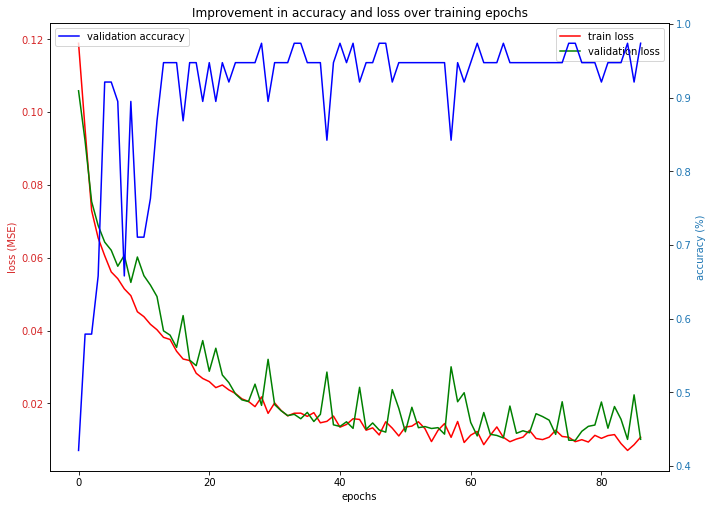

In [646]:
fig, ax1 = plt.subplots(figsize=(10, 7))

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss (MSE)', color=color)
ax1.plot(mlp.train_loss, color='r', label="train loss")
ax1.plot(mlp.val_loss, color='g', label="validation loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(mlp.val_score, color='b', label="validation accuracy")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Improvement in accuracy and loss over training epochs")
plt.show()

# Vowel

In [649]:
import arff
path = r'vowels.arff'
data = arff.Arff(arff=path, label_count=1)
X = data[:, 2:-1]
y = onehot_encode(data[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

## Baseline

In [650]:
mlp = MLPClassifier([22], lr=0.1, max_iter=500)
mlp.fit(X_train, y_train)

Model converged after 273 iterations.


MLPClassifier(hidden_layer_widths=[22], lr=0.1, max_iter=500, momentum=0,
              shuffle=True)

In [651]:
mlp.score(X_test, y_test)

0.782258064516129

## LR Experiment

In [653]:
lr_list = np.logspace(-3, 1, 13)
train_mse_list = []
val_mse_list = []
test_mse_list = []
num_epochs = []
for lr in lr_list:
    train_mse = 0
    val_mse = 0
    test_mse = 0
    n = 0
    for _ in range(3):
        mlp = MLPClassifier([22], lr=lr, max_iter=5000)
        mlp.fit(X_train, y_train)
        train_mse += mlp.train_loss[-1]
        val_mse += mlp.val_loss[-1]
        test_mse += mlp.average_loss(X_test, y_test)
        n += mlp.num_iter
    train_mse /= 3
    val_mse /= 3
    test_mse /= 3
    n /= 3
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    test_mse_list.append(test_mse)
    num_epochs.append(n)
    print("learning rate: {}".format(lr))
    print("train mse:\t{}".format(train_mse))
    print("val mse:\t{}". format(val_mse))
    print("test mse:\t{}".format(test_mse))
    print("num epochs:\t{}".format(n))
    print()

Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
learning rate: 0.001
train mse:	0.020325222179184404
val mse:	0.02456480765558321
test mse:	0.0244310726526013
num epochs:	4999.0

Model converged after 4633 iterations.
Model converged after 4928 iterations.
Model converged after 2885 iterations.
learning rate: 0.0021544346900318843
train mse:	0.016163837895932093
val mse:	0.019869618032362046
test mse:	0.020662324228280095
num epochs:	4148.666666666667

Model converged after 3443 iterations.
Model converged after 1644 iterations.
Model converged after 2083 iterations.
learning rate: 0.004641588833612777
train mse:	0.013265538905542981
val mse:	0.01842411224103388
test mse:	0.01890483367003327
num epochs:	2390.0

Model converged after 887 iterations.
Model converged after 631 iterations.
Model converged after 1045 iterations.
learning rate: 0.01
train mse:	0.01458347846983308
val mse:	0.01902756264750591
test mse:	0.019467

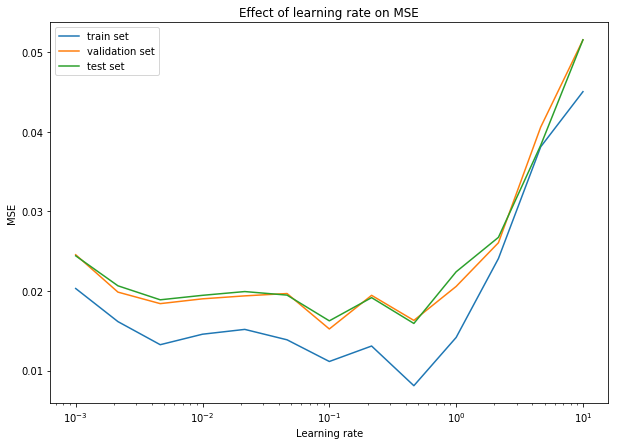

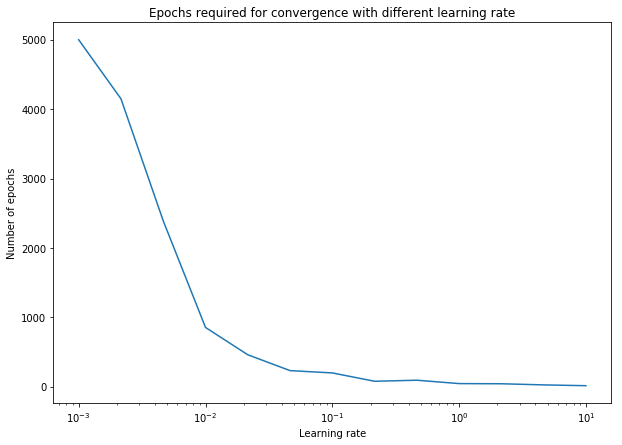

In [656]:
plt.figure(figsize=(10, 7))
plt.semilogx(lr_list, train_mse_list, label="train set")
plt.semilogx(lr_list, val_mse_list, label="validation set")
plt.semilogx(lr_list, test_mse_list, label="test set")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.legend()
plt.title("Effect of learning rate on MSE")
plt.show()
plt.figure(figsize=(10, 7))
plt.semilogx(lr_list, num_epochs)
plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.title("Epochs required for convergence with different learning rate")
plt.show()

## Node Experiment

In [655]:
best_lr = lr_list[np.array(val_mse_list).argmin()]
best_lr

0.1

In [657]:
train_mse_list = []
val_mse_list = []
test_mse_list = []
n = 1
acc = 0
while True:
    train_mse = 0
    val_mse = 0
    test_mse = 0
    curr_score = 0
    for _ in range(3):
        mlp = MLPClassifier([n], lr=best_lr, max_iter=500)
        mlp.fit(X_train, y_train)
        train_mse += mlp.train_loss[-1]
        val_mse += mlp.val_loss[-1]
        test_mse += mlp.average_loss(X_test, y_test)
        curr_score += mlp.val_score[-1]
    
    train_mse /= 3
    val_mse /= 3
    test_mse /= 3
    curr_score /= 3
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    test_mse_list.append(test_mse)
    print("Nodes: {}".format(n))
    print("train mse:\t{}".format(train_mse))
    print("val mse:\t{}". format(val_mse))
    print("test mse:\t{}".format(test_mse))
    print("accuracy:\t{}".format(curr_score))
    print()
    if curr_score < acc:
        break
    acc = curr_score
    n *= 2

Model converged after 155 iterations.
Model converged after 12 iterations.
Model converged after 114 iterations.
Nodes: 1
train mse:	0.03944415092302953
val mse:	0.03991010448477913
test mse:	0.03953769660555248
accuracy:	0.14336917562724014

Model converged after 16 iterations.
Model converged after 160 iterations.
Model converged after 19 iterations.
Nodes: 2
train mse:	0.03791822559819091
val mse:	0.03814473211322552
test mse:	0.038249478993651755
accuracy:	0.21505376344086022

Model converged after 212 iterations.
Model converged after 79 iterations.
Model converged after 164 iterations.
Nodes: 4
train mse:	0.02895020764588699
val mse:	0.029915217832054548
test mse:	0.028984847402193762
accuracy:	0.4767025089605735

Model converged after 122 iterations.
Model converged after 196 iterations.
Model converged after 239 iterations.
Nodes: 8
train mse:	0.01899204681866383
val mse:	0.022577782182284983
test mse:	0.022211980276832355
accuracy:	0.6433691756272402

Model converged after 187

In [658]:
num_nodes = [2**i for i in range(len(train_mse_list))]
num_nodes

[1, 2, 4, 8, 16, 32, 64]

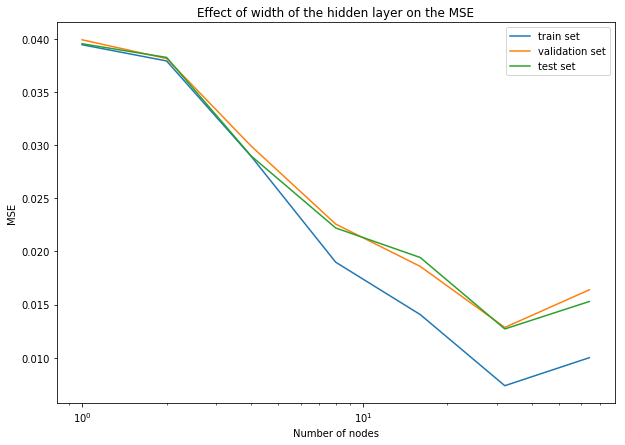

In [659]:
plt.figure(figsize=(10,7))
plt.semilogx(num_nodes, train_mse_list, label="train set")
plt.semilogx(num_nodes, val_mse_list, label="validation set")
plt.semilogx(num_nodes, test_mse_list, label="test set")
plt.xlabel("Number of nodes")
plt.ylabel("MSE")
plt.title("Effect of width of the hidden layer on the MSE")
plt.legend()
plt.show()

## Momentum Experiment

In [665]:
best_nodes = num_nodes[np.array(val_mse_list).argmin()]

In [668]:
momentum = np.linspace(0, 0.99, 21)
momentum

array([0.    , 0.0495, 0.099 , 0.1485, 0.198 , 0.2475, 0.297 , 0.3465,
       0.396 , 0.4455, 0.495 , 0.5445, 0.594 , 0.6435, 0.693 , 0.7425,
       0.792 , 0.8415, 0.891 , 0.9405, 0.99  ])

In [669]:
acc = 0
num_epochs = []
for m in momentum:
    n = 0
    curr_score = 0
    for _ in range(3):
        mlp = MLPClassifier([best_nodes], lr=best_lr, momentum=m, max_iter=500)
        mlp.fit(X_train, y_train)
        n += mlp.num_iter
        curr_score += mlp.val_score[-1]
    
    n /= 3
    curr_score /= 3
    
    num_epochs.append(n)
    print("Momentum:\t{}".format(m))
    print("num epochs:\t{}".format(n))
    print("accuracy:\t{}".format(curr_score))
    print()
    acc = curr_score

Model converged after 182 iterations.
Model converged after 277 iterations.
Model converged after 128 iterations.
Momentum:	0.0
num epochs:	195.66666666666666
accuracy:	0.8136200716845877

Model converged after 129 iterations.
Model converged after 115 iterations.
Model converged after 194 iterations.
Momentum:	0.0495
num epochs:	146.0
accuracy:	0.7491039426523297

Model converged after 188 iterations.
Model converged after 194 iterations.
Model converged after 241 iterations.
Momentum:	0.099
num epochs:	207.66666666666666
accuracy:	0.8476702508960573

Model converged after 132 iterations.
Model converged after 140 iterations.
Model converged after 96 iterations.
Momentum:	0.14850000000000002
num epochs:	122.66666666666667
accuracy:	0.7293906810035843

Model converged after 152 iterations.
Model converged after 150 iterations.
Model converged after 154 iterations.
Momentum:	0.198
num epochs:	152.0
accuracy:	0.8279569892473119

Model converged after 196 iterations.
Model converged after

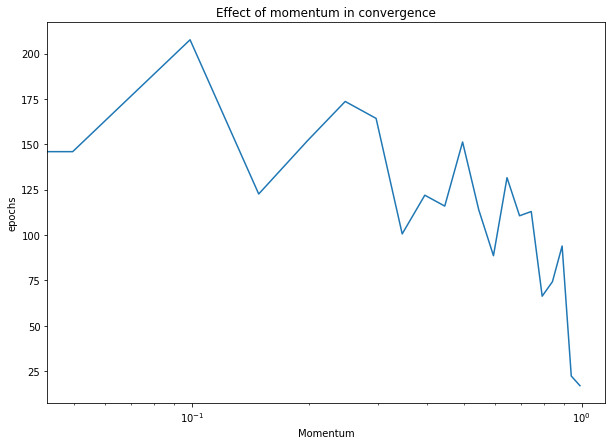

In [671]:
plt.figure(figsize=(10,7))
plt.semilogx(momentum, num_epochs)
plt.xlabel("Momentum")
plt.ylabel("epochs")
plt.title("Effect of momentum in convergence")
plt.show()

In [8]:
from sklearn.neural_network import MLPClassifier

In [674]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y_a = iris.target
y = y_a.reshape(-1, 1)
y_onehot = onehot_encode(y_a)
y_onehot
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot)

In [690]:
mlp = MLPClassifier(hidden_layer_sizes=[8], activation="logistic", max_iter=10000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[8], learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [691]:
mlp.score(X_test, y_test)

1.0

In [692]:
import arff
path = r'vowels.arff'
vowel = arff.Arff(arff=path, label_count=1)
X = data[:, 2:-1]
y = onehot_encode(data[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [740]:
mlp = MLPClassifier(hidden_layer_sizes=[16, 32, 64, 32, 16], learning_rate_init=0.01, early_stopping=True, n_iter_no_change=100, activation="relu", max_iter=10000, alpha=0.1)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[16, 32, 64, 32, 16], learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [741]:
mlp.score(X_test, y_test)

0.9233870967741935

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y_a = digits.target
y = y_a.reshape(-1, 1)
y_onehot = onehot_encode(y_a)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot)

In [14]:
lr_list = np.logspace(-3, 0, 20)
alpha_list = np.logspace(-3, -0.5, 10)

In [ ]:
scores = []
for lr in lr_list:
    for alpha in alpha_list:
        mlp = MLPClassifier(hidden_layer_sizes=[64, 128, 256, 128, 64], learning_rate_init=lr, alpha=alpha, activation="relu", max_iter=500)
        mlp.fit(X_train, y_train)
        score = mlp.score(X_test, y_test)
        scores.append((lr, alpha, score))
        print(lr, alpha, score)

0.001 0.001 0.9644444444444444
0.001 0.0018957356524063754 0.9644444444444444
0.001 0.003593813663804626 0.9733333333333334
0.001 0.006812920690579615 0.9577777777777777
0.001 0.01291549665014884 0.9666666666666667
0.001 0.024484367468222266 0.9688888888888889
0.001 0.046415888336127795 0.96
0.001 0.08799225435691074 0.8022222222222222
0.001 0.1668100537200059 0.9644444444444444
0.001 0.31622776601683794 0.9622222222222222
0.0014384498882876629 0.001 0.9555555555555556
0.0014384498882876629 0.0018957356524063754 0.9622222222222222
0.0014384498882876629 0.003593813663804626 0.9666666666666667
0.0014384498882876629 0.006812920690579615 0.9511111111111111
0.0014384498882876629 0.01291549665014884 0.96
0.0014384498882876629 0.024484367468222266 0.9622222222222222
0.0014384498882876629 0.046415888336127795 0.9755555555555555
0.0014384498882876629 0.08799225435691074 0.9777777777777777
0.0014384498882876629 0.1668100537200059 0.9644444444444444
0.0014384498882876629 0.31622776601683794 0.966

/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.05455594781168517 0.08799225435691074 0.0


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.05455594781168517 0.1668100537200059 0.0
0.05455594781168517 0.31622776601683794 0.28
0.07847599703514611 0.001 0.0
0.07847599703514611 0.0018957356524063754 0.0
0.07847599703514611 0.003593813663804626 0.09111111111111111
0.07847599703514611 0.006812920690579615 0.0
0.07847599703514611 0.01291549665014884 0.0


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.07847599703514611 0.024484367468222266 0.0


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.07847599703514611 0.046415888336127795 0.0


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.07847599703514611 0.08799225435691074 0.07111111111111111
0.07847599703514611 0.1668100537200059 0.06444444444444444


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.07847599703514611 0.31622776601683794 0.0
0.11288378916846883 0.001 0.0
0.11288378916846883 0.0018957356524063754 0.0
0.11288378916846883 0.003593813663804626 0.0
0.11288378916846883 0.006812920690579615 0.0
0.11288378916846883 0.01291549665014884 0.0


/Users/seong-euncho/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.11288378916846883 0.024484367468222266 0.0


In [18]:
scores

[(0.001, 0.001, 0.96)]

In [758]:
lr_list

array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])